In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_out= dir_ssp_modeling.joinpath("ssp_run/bau")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
dir_scenario_mapping

PosixPath('/home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/scenario_mapping')

In [5]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [6]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "bau_config.yaml")
config_params = g_utils.read_yaml(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  uganda
SSP input file name:  ssp_inputs_uganda_BaU_Scenario.csv
SSP transformation CW:  ssp_uganda_transformation_cw_bau.xlsx
Energy model flag:  False
Set lndu reallocation factor to zero flag:  True


In [7]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [8]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [9]:
?g_utils.check_frac_groups

Signature: g_utils.check_frac_groups(ssp_input_df, frac_vars_mapping_file_path)
Docstring:
Checks if the sum of fractional groups in the input DataFrame is within the range [0, 1].
This function reads a mapping file to identify subgroups of columns in the input DataFrame.
For each subgroup, it calculates the row-wise sum of the columns and checks if the sums are within the range [0, 1].
If any row sum is outside this range, a message is printed indicating the issue.
Args:
    ssp_input_df (pd.DataFrame): The input DataFrame containing the data to be checked.
    frac_vars_mapping_file_path (str): The file path to the Excel file containing the mapping of fractional variables.
Returns:
    None
File:      ~/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/ssp_transformations_handler/GeneralUtils.py
Type:      function

In [10]:
help(g_utils.remove_additional_cols)

Help on function remove_additional_cols in module ssp_transformations_handler.GeneralUtils:

remove_additional_cols(df_example, df_input)
    Remove columns from df_input that are not present in df_example.
    Parameters:
    df_example (pandas.DataFrame): The reference DataFrame containing the desired columns.
    df_input (pandas.DataFrame): The DataFrame from which additional columns will be removed.
    Returns:
    pandas.DataFrame: A DataFrame with only the columns present in df_example.



In [11]:
df_inputs_raw = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw)

In [12]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,frac_lvst_mm_sheep_anaerobic_lagoon,ef_lndu_conv_other_to_forests_primary_gg_co2_ha,ef_lndu_conv_other_to_forests_mangroves_gg_co2_ha,pij_lndu_other_to_forests_mangroves,frac_lvst_mm_cattle_nondairy_dry_lot,frac_lvst_mm_buffalo_paddock_pasture_range,pij_lndu_settlements_to_settlements,frac_lvst_mm_pigs_anaerobic_lagoon,frac_agrc_nuts_cl1_temperate,pij_lndu_forests_primary_to_forests_mangroves,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,0,0,0,0,0.3,0.45,1,0.025,0.030468,0,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [13]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: set()


In [14]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    uganda
1    uganda
2    uganda
3    uganda
4    uganda
Name: region, dtype: object

# frac_lndu_initial modification

In [15]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]


frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.191637
frac_lndu_initial_forests_primary      0.088106
frac_lndu_initial_settlements          0.002294
frac_lndu_initial_forests_secondary    0.017221
frac_lndu_initial_other                0.019260
frac_lndu_initial_grasslands           0.219108
frac_lndu_initial_croplands            0.462375
Name: 0, dtype: float64

In [16]:
james = pd.read_csv(os.path.join(dir_data, "ssp_inputs_uganda_asp_scenario_with_dijis_inputs_and_adj_qmats.csv"))

In [17]:
df_inputs_raw_complete["frac_lndu_initial_forests_primary"] = james["frac_lndu_initial_forests_primary"] 
df_inputs_raw_complete["frac_lndu_initial_forests_secondary"] = james["frac_lndu_initial_forests_secondary"]
df_inputs_raw_complete['frac_lndu_initial_forests_mangroves'] = james['frac_lndu_initial_forests_mangroves']
df_inputs_raw_complete['frac_lndu_initial_grasslands'] = james['frac_lndu_initial_grasslands']
df_inputs_raw_complete['frac_lndu_initial_settlements'] = james['frac_lndu_initial_settlements'] 
df_inputs_raw_complete['frac_lndu_initial_wetlands'] = james['frac_lndu_initial_wetlands']
df_inputs_raw_complete['frac_lndu_initial_croplands'] = james['frac_lndu_initial_croplands']
df_inputs_raw_complete['frac_lndu_initial_other'] = james['frac_lndu_initial_other']

In [18]:
df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "frac_lndu_initial_" in i]].iloc[0]

frac_lndu_initial_forests_mangroves    0.000000
frac_lndu_initial_wetlands             0.043018
frac_lndu_initial_forests_primary      0.025318
frac_lndu_initial_settlements          0.009043
frac_lndu_initial_forests_secondary    0.129856
frac_lndu_initial_other                0.000548
frac_lndu_initial_grasslands           0.266578
frac_lndu_initial_croplands            0.525639
Name: 0, dtype: float64

# Trancision Matrix

In [19]:
pij_ex =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_" in i]].columns
pij_ex

Index(['pij_lndu_croplands_to_croplands',
       'pij_lndu_croplands_to_forests_mangroves',
       'pij_lndu_croplands_to_forests_primary',
       'pij_lndu_croplands_to_forests_secondary',
       'pij_lndu_croplands_to_grasslands', 'pij_lndu_croplands_to_other',
       'pij_lndu_croplands_to_settlements', 'pij_lndu_croplands_to_wetlands',
       'pij_lndu_forests_mangroves_to_croplands',
       'pij_lndu_forests_mangroves_to_forests_mangroves',
       'pij_lndu_forests_mangroves_to_forests_primary',
       'pij_lndu_forests_mangroves_to_forests_secondary',
       'pij_lndu_forests_mangroves_to_grasslands',
       'pij_lndu_forests_mangroves_to_other',
       'pij_lndu_forests_mangroves_to_settlements',
       'pij_lndu_forests_mangroves_to_wetlands',
       'pij_lndu_forests_primary_to_croplands',
       'pij_lndu_forests_primary_to_forests_mangroves',
       'pij_lndu_forests_primary_to_forests_primary',
       'pij_lndu_forests_primary_to_forests_secondary',
       'pij_lndu_forests

In [20]:
pij_lndu_croplands =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_lndu_croplands_to" in i]].columns
df_inputs_raw_complete[pij_lndu_croplands].tail()

,pij_lndu_croplands_to_croplands,pij_lndu_croplands_to_forests_mangroves,pij_lndu_croplands_to_forests_primary,pij_lndu_croplands_to_forests_secondary,pij_lndu_croplands_to_grasslands,pij_lndu_croplands_to_other,pij_lndu_croplands_to_settlements,pij_lndu_croplands_to_wetlands
31,0.995995,0,0,0.000007,0,0,0,0.003998
32,0.995995,0,0,0.000007,0,0,0,0.003998
33,0.995995,0,0,0.000007,0,0,0,0.003998
34,0.995995,0,0,0.000007,0,0,0,0.003998
35,0.995995,0,0,0.000007,0,0,0,0.003998


In [21]:
df_inputs_raw_complete[pij_ex] = james[pij_ex]

In [22]:
df_inputs_raw_complete[pij_lndu_croplands].tail()

,pij_lndu_croplands_to_croplands,pij_lndu_croplands_to_forests_mangroves,pij_lndu_croplands_to_forests_primary,pij_lndu_croplands_to_forests_secondary,pij_lndu_croplands_to_grasslands,pij_lndu_croplands_to_other,pij_lndu_croplands_to_settlements,pij_lndu_croplands_to_wetlands
31,0.999656,0,0,0.000344,0,0,0,0.0
32,0.999746,0,0,0.000254,0,0,0,0.0
33,0.999828,0,0,0.000172,0,0,0,0.0
34,0.999894,0,0,0.000106,0,0,0,0.0
35,0.999894,0,0,0.000106,0,0,0,0.0


In [23]:
pop_lvst_initial =  df_inputs_example[[i for i in df_inputs_example.columns if "pop_lvst_initial" in i]].columns
pop_lvst_initial 


Index(['pop_lvst_initial_buffalo', 'pop_lvst_initial_cattle_dairy',
       'pop_lvst_initial_cattle_nondairy', 'pop_lvst_initial_chickens',
       'pop_lvst_initial_goats', 'pop_lvst_initial_horses',
       'pop_lvst_initial_mules', 'pop_lvst_initial_pigs',
       'pop_lvst_initial_sheep'],
      dtype='object')

In [24]:

# implement models -> import sispeuede.manager.sisepuede_models as sm
import sisepuede.manager.sisepuede_models as sm

models = sm.SISEPUEDEModels(
    matt,
    allow_electricity_run = False,
)

##  DO THE ADJUSTMENTS HERE TO BASELINE INPUTS FILE

df_inputs = df_inputs_raw_complete.copy()

modvar_agrc_yf = matt.get_variable(models.model_afolu.modvar_agrc_yf)
modvar_lndu_area = matt.get_variable(models.model_afolu.modvar_lndu_area_by_cat)
modvar_lndu_frac_pasture = matt.get_variable(models.model_afolu.modvar_lndu_frac_grassland_that_is_pasture)
modvar_lvst_cc_scalar = matt.get_variable(models.model_afolu.modvar_lvst_carrying_capacity_scalar, )
modvar_lvst_demand = matt.get_variable(models.model_afolu.modvar_lvst_demand_livestock, )
modvar_lvst_pop = matt.get_variable(models.model_afolu.modvar_lvst_pop, )

In [25]:
df_inputs["elasticity_ippu_wood_production_to_gdp"].head()

0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
Name: elasticity_ippu_wood_production_to_gdp, dtype: float64

In [26]:
df_inputs["elasticity_ippu_wood_production_to_gdp"] = 0

In [27]:
df_inputs["elasticity_ippu_wood_production_to_gdp"].head()

0    0
1    0
2    0
3    0
4    0
Name: elasticity_ippu_wood_production_to_gdp, dtype: int64

In [28]:
##  UPDATE CARRYING CAPACITY

array_scale = matt.extract_model_variable(
    df_inputs_raw_complete,
    modvar_lvst_cc_scalar,
    override_vector_for_single_mv_q = True,
    return_type = "array_base",
)

vec_scale_capacity = sf.ramp_vector(
    df_inputs_raw_complete.shape[0],
    r_0 = 10,
)*0.5 + 1

df_inputs[modvar_lvst_cc_scalar.fields] = sf.do_array_mult(
    array_scale,
    vec_scale_capacity
)

In [29]:
##  UPDATE PASTURE FRACTION

array_frac_pasture = matt.extract_model_variable(
    df_inputs_raw_complete,
    modvar_lndu_frac_pasture,
    override_vector_for_single_mv_q = True,
    return_type = "array_base",
)

vec_adjust_pasture = sf.ramp_vector(
    df_inputs_raw_complete.shape[0],
    r_0 = 5,
)*(6.439197e+06/4.014804e+06 - 1) + 1 # est values of grassland at time 0 and 35

df_inputs[modvar_lndu_frac_pasture.fields] = sf.do_array_mult(
    array_frac_pasture,
    vec_adjust_pasture
)

df_out = models.project(df_inputs, )


In [30]:
# you can add the new gdp to df_inputs_high_gdp
df_inputs_raw_complete = df_inputs

In [31]:
pij_lndu_forests_primary =  df_inputs_example[[i for i in df_inputs_example.columns if "pij_lndu_forests_primary_to" in i]].columns
df_inputs_raw_complete[pij_lndu_forests_primary].tail()

,pij_lndu_forests_primary_to_croplands,pij_lndu_forests_primary_to_forests_mangroves,pij_lndu_forests_primary_to_forests_primary,pij_lndu_forests_primary_to_forests_secondary,pij_lndu_forests_primary_to_grasslands,pij_lndu_forests_primary_to_other,pij_lndu_forests_primary_to_settlements,pij_lndu_forests_primary_to_wetlands
31,0.013984,0,0.985625,0,0.000005,0.000356,0,0.000031
32,0.013983,0,0.985601,0,0.000005,0.000377,0,0.000033
33,0.013981,0,0.985596,0,0.000005,0.000385,0,0.000033
34,0.013981,0,0.985564,0,0.000006,0.000411,0,0.000038
35,0.013981,0,0.985564,0,0.000006,0.000411,0,0.000038


<Axes: >

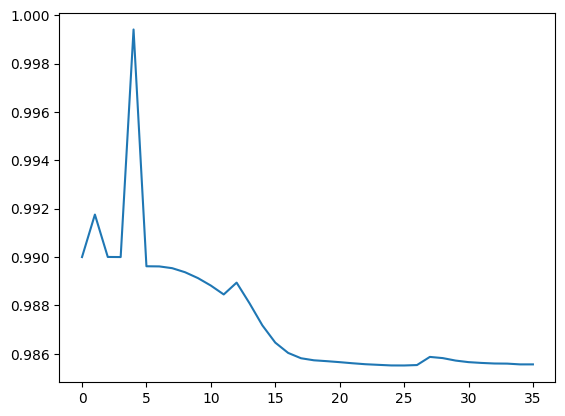

In [32]:
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_primary'].plot()

<Axes: >

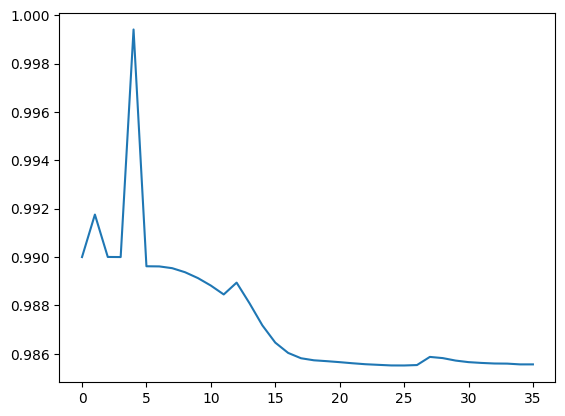

In [33]:
df_inputs_raw_complete['pij_lndu_forests_primary_to_forests_primary'].plot()

<Axes: >

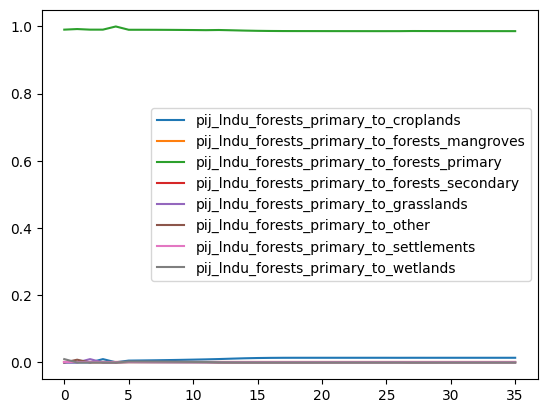

In [34]:
df_inputs_raw_complete[pij_lndu_forests_primary].plot()

## Let's Modify the  LNDU Reallocation factor

In [35]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

In [36]:
# Número de pasos entre time_period 20 y 35 (inclusive)
start, end = 10, 35
n_steps = end - start + 1

# Generar la serie progresiva lineal de 0 a 0.02
series = np.linspace(0, 0.0026666, n_steps)

# Asignar los valores a la columna lndu_reallocation_factor para los time_period deseados
df_inputs_raw_complete.loc[
    df_inputs_raw_complete["time_period"].between(start, end), 
    "lndu_reallocation_factor"
] = series

In [37]:
df_inputs_raw_complete[['time_period','lndu_reallocation_factor']].tail(10)

,time_period,lndu_reallocation_factor
26,26,0.001707
27,27,0.001813
28,28,0.001920
29,29,0.002027
30,30,0.002133
31,31,0.002240
32,32,0.002347
33,33,0.002453
34,34,0.002560
35,35,0.002667


## Evolution gdp_mmm_usd BaU Scenario

In [38]:
df_inputs_raw_complete['gdp_mmm_usd'].tail()

31    443.314127
32    483.212399
33    526.701514
34    574.104651
35    625.774069
Name: gdp_mmm_usd, dtype: float64

In [39]:
df_inputs_raw_complete = df_inputs_raw_complete.sort_values("time_period")
df_inputs_raw_complete["gdp_mmm_usd_pct_change"] = df_inputs_raw_complete["gdp_mmm_usd"].pct_change() * 100

In [40]:
df_inputs_raw_complete[['time_period','gdp_mmm_usd','gdp_mmm_usd_pct_change']].tail()

,time_period,gdp_mmm_usd,gdp_mmm_usd_pct_change
31,31,443.314127,9.0
32,32,483.212399,9.0
33,33,526.701514,9.0
34,34,574.104651,9.0
35,35,625.774069,9.0


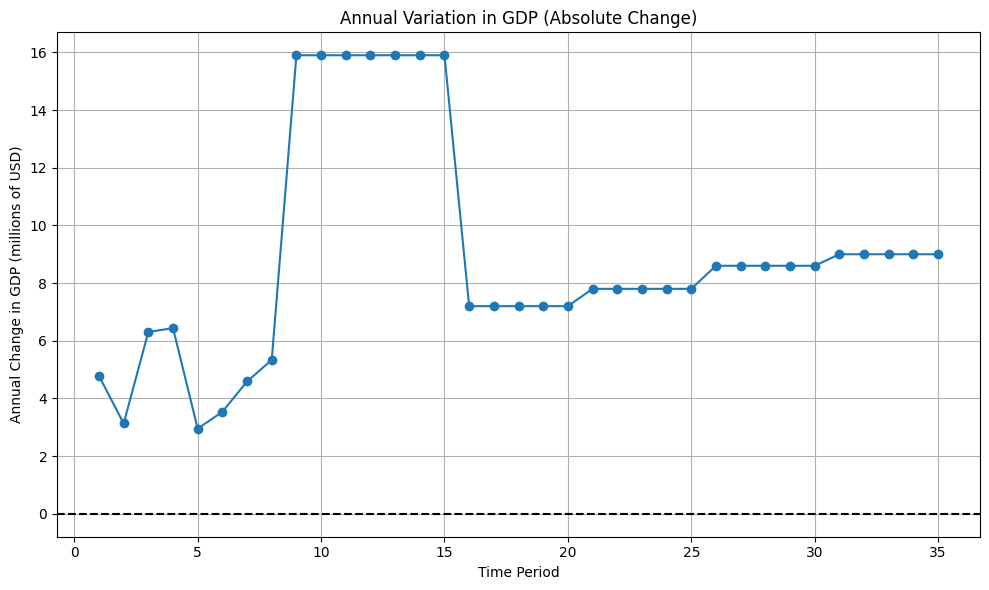

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd_pct_change"], marker='o', linestyle='-')

plt.xlabel("Time Period")
plt.ylabel("Annual Change in GDP (millions of USD)")
plt.title("Annual Variation in GDP (Absolute Change)")
plt.axhline(0, color='black', linestyle='--')  # Línea base
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

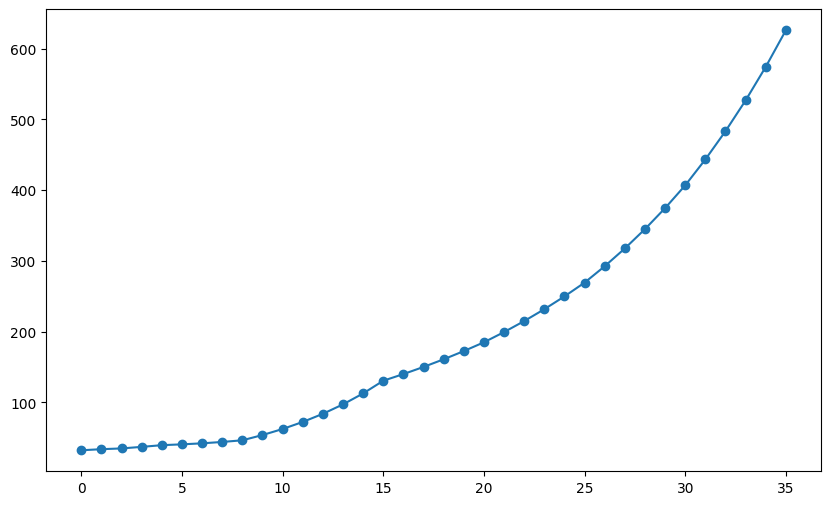

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd"], marker='o')

plt.show()

In [43]:
pop_lvst_initial =  df_inputs_raw_complete[[i for i in df_inputs_raw_complete.columns if "pop_lvst_initial" in i]].columns
pop_lvst_initial 

pop_lvst_initial

Index(['pop_lvst_initial_chickens', 'pop_lvst_initial_goats',
       'pop_lvst_initial_cattle_nondairy', 'pop_lvst_initial_horses',
       'pop_lvst_initial_mules', 'pop_lvst_initial_cattle_dairy',
       'pop_lvst_initial_sheep', 'pop_lvst_initial_pigs',
       'pop_lvst_initial_buffalo'],
      dtype='object')

In [44]:
df_inputs_raw_complete[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,33246,14272733,14031000,0,0,14031000,1918651,2461661,0
1,33941,15806305,14368000,0,0,14368000,2066324,2479272,0
2,35041,16235658,14189000,0,0,14189000,2116855,2501459,0
3,34137,16491153,14572000,0,0,14572000,2154474,2526885,0
4,34942,15920638,14785000,0,0,14785000,2086461,2516546,0


In [45]:
tony = pd.read_csv(os.path.join(dir_data, "UGA_real_data_20250429.csv"))
tony[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,46039000.0,15312000.0,14031000.0,0.0,19220.0,14031000.0,3842000.0,3916000.0,0.0
1,46291000.0,15725000.0,14368000.0,0.0,19247.0,14368000.0,4198000.0,4037000.0,0.0
2,47578000.0,16034000.0,14189000.0,0.0,19277.0,14189000.0,4445000.0,4109000.0,0.0
3,48901000.0,16419000.0,14572000.0,0.0,19310.0,14572000.0,4584000.0,4245000.0,0.0
4,43121000.0,16945000.0,14785000.0,0.0,19343.0,14785000.0,4666000.0,4411000.0,0.0


In [46]:
df_inputs_raw_complete[pop_lvst_initial] = tony[pop_lvst_initial]

In [47]:
df_inputs_raw_complete[pop_lvst_initial].head()

,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_cattle_dairy,pop_lvst_initial_sheep,pop_lvst_initial_pigs,pop_lvst_initial_buffalo
0,46039000.0,15312000.0,14031000.0,0.0,19220.0,14031000.0,3842000.0,3916000.0,0.0
1,46291000.0,15725000.0,14368000.0,0.0,19247.0,14368000.0,4198000.0,4037000.0,0.0
2,47578000.0,16034000.0,14189000.0,0.0,19277.0,14189000.0,4445000.0,4109000.0,0.0
3,48901000.0,16419000.0,14572000.0,0.0,19310.0,14572000.0,4584000.0,4245000.0,0.0
4,43121000.0,16945000.0,14785000.0,0.0,19343.0,14785000.0,4666000.0,4411000.0,0.0


#  Let's try building transformations using this


In [48]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [49]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [50]:
?TransformationYamlProcessor

Init signature:
TransformationYamlProcessor(
    scenario_mapping_excel_path,
    yaml_dir_path,
    sheet_name='yaml',
)
Docstring:     
TransformationYamlProcessor is a class designed to handle the processing of YAML files based on scenario mappings provided in an Excel file. It provides methods to load scenario mappings, retrieve strategy names, load YAML data, save modified YAML files, and process YAML files according to specified transformations.
Methods:
    __init__(self, scenario_mapping_excel_path, yaml_dir_path, sheet_name='yaml'):
        Initializes the TransformationYamlProcessor class with the given parameters.
    load_scenario_mapping_excel(self):
    load_yaml_data(self, yaml_file_path):
    get_strategy_names(self):
    save_yaml_file(self, yaml_content, yaml_name, column, transformation_code, subsector, transformation_name, scalar_val):
    get_transformations_per_strategy_dict(self):
    process_yaml_files(self):
Init docstring:
Initializes the TransformationUtils c

In [51]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_bau.xlsx


In [52]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_agrc_inc_conservation_agriculture.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_inen_shift_fuel_heat.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NDC. Please check it manually.
YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lsmm_inc_management_poultry.yaml already exist for strategy strategy_NDC. Please check it manua

In [53]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NDC',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC',
  'TX:IPPU:DEC_DEMAND_STRATEGY_NDC',
  'TX:IPPU:DEC_HFCS_STRATEGY_NDC',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC',
  'TX:TRDE:DEC_DEMAND_STRATEGY_NDC',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC',
  'TX:TRN

In [54]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NDC', 'strategy_NZ', 'strategy_BAU'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [55]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

#csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')
csv_handler.add_strategy(strategy_group='PFLO', description='S BAU', yaml_file_suffix='BAU')


INFO: Strategy code PFLO:NDC already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NDC
INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:NZ
INFO: Strategy code PFLO:BAU already exists in the strategy definitions. Strategy will be updated...
Updated row with strategy_code PFLO:BAU


In [56]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004, 6005]

# Manual modification YAML

## TX:LNDU:DEC_DEFORESTATION

In [57]:

import yaml

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.9999999   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

  

In [58]:

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.996


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [59]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [60]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [61]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [62]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/fabian_fuentes/repos/ssp_uganda_private/ssp_modeling/transformations initialized in 2.65 seconds


In [63]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC,NDC,NDC,TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC|TX:AGRC:INC_...,0
70,6004,PFLO:NZ,NZ,Net Zero,TX:SCOE:DEC_DEMAND_HEAT_STRATEGY_NZ|TX:AGRC:DE...,0
71,6005,PFLO:BAU,BAU,S BAU,TX:LVST:INC_PRODUCTIVITY_STRATEGY_BAU|TX:AGRC:...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [64]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2220)
strat 6003 with output shape (36, 2220)
here = 6003
starting strat 6004 with input shape (36, 2220)
strat 6004 with output shape (36, 2220)
here = 6004
starting strat 6005 with input shape (36, 2220)
strat 6005 with output shape (36, 2220)
here = 6005


0

# Finally, load SISEPUEDE so that we can run it

In [65]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-05-06 10:53:09,854 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-05-06 10:53:09,856 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-05-06 10:53:09,857 - INFO - 	Setting export engine to 'csv'.
2025-05-06 10:53:09,858 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-05-06 10:53:09,858 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-05-06 10:53:09,859 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-05-06 10:53:09,859 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-05-06 10:53:09,860 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-05-06 10:53:09,860 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-05-06 10:53:09,861 - WARNING - No index fi

In [66]:
not(energy_model_flag)

True

In [67]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-05-06 10:53:33,355 - INFO - 
***	STARTING REGION uganda	***

2025-05-06 10:53:36,452 - INFO - Trying run primary_id = 0 in region uganda
2025-05-06 10:53:36,452 - INFO - Running AFOLU model
2025-05-06 10:53:36,620 - INFO - AFOLU model run successfully completed
2025-05-06 10:53:36,620 - INFO - Running CircularEconomy model
2025-05-06 10:53:36,675 - INFO - CircularEconomy model run successfully completed
2025-05-06 10:53:36,676 - INFO - Running IPPU model
2025-05-06 10:53:36,765 - INFO - IPPU model run successfully completed
2025-05-06 10:53:36,765 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-05-06 10:53:36,798 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-05-06 10:53:36,874 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-05-06 10:53:36,875 - INFO - Running Energy (Fugitive Emissions)
2025-05-06 10:53:36,909 - E

{'uganda': [0, 69069, 70070, 71071]}

In [68]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [69]:
matt.get_all_subsector_emission_total_fields()

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ccsq',
 'emission_co2e_subsector_total_entc',
 'emission_co2e_subsector_total_fgtv',
 'emission_co2e_subsector_total_inen',
 'emission_co2e_subsector_total_scoe',
 'emission_co2e_subsector_total_trns',
 'emission_co2e_subsector_total_ippu']

In [70]:
df_out['emission_co2e_subsector_total_agrc'].tail()

139    37.658744
140    37.957516
141    38.255549
142    38.551723
143    38.843971
Name: emission_co2e_subsector_total_agrc, dtype: float64

In [71]:
df_out['primary_id'].unique()

array([    0, 69069, 70070, 71071])

## BAU

<Axes: >

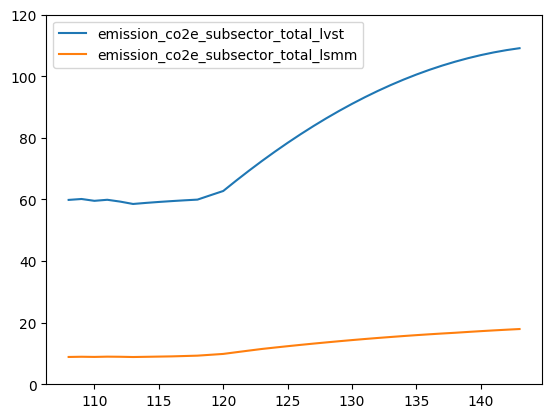

In [72]:
df_out[df_out['primary_id'] == 71071][['emission_co2e_subsector_total_lvst', 'emission_co2e_subsector_total_lsmm']].plot(ylim=(0,120))


## NDC

<Axes: >

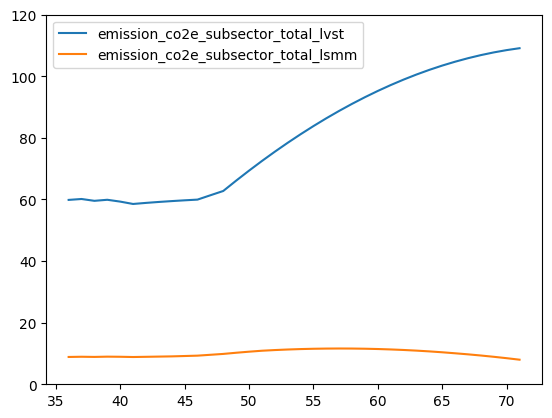

In [73]:
df_out[df_out['primary_id'] == 69069][['emission_co2e_subsector_total_lvst', 'emission_co2e_subsector_total_lsmm']].plot(ylim=(0,120))

## Net Zero

<Axes: >

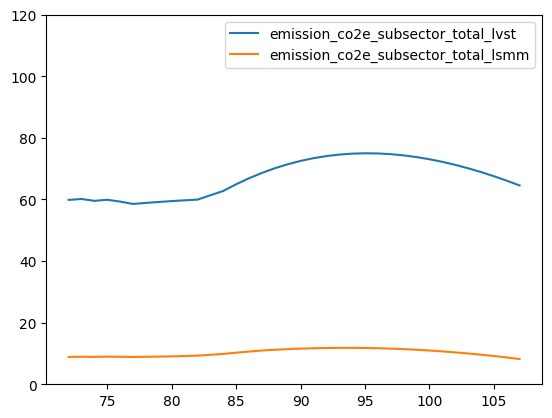

In [74]:
df_out[df_out['primary_id'] == 70070][['emission_co2e_subsector_total_lvst', 'emission_co2e_subsector_total_lsmm']].plot(ylim=(0,120))

In [75]:
df_plot = df_out[df_out['time_period']==35]

df_plot[['primary_id','emission_co2e_subsector_total_frst']].tail()

,primary_id,emission_co2e_subsector_total_frst
35,0,-4.782932
71,69069,-6.679233
107,70070,-7.016690
143,71071,-4.836406


## Baseline

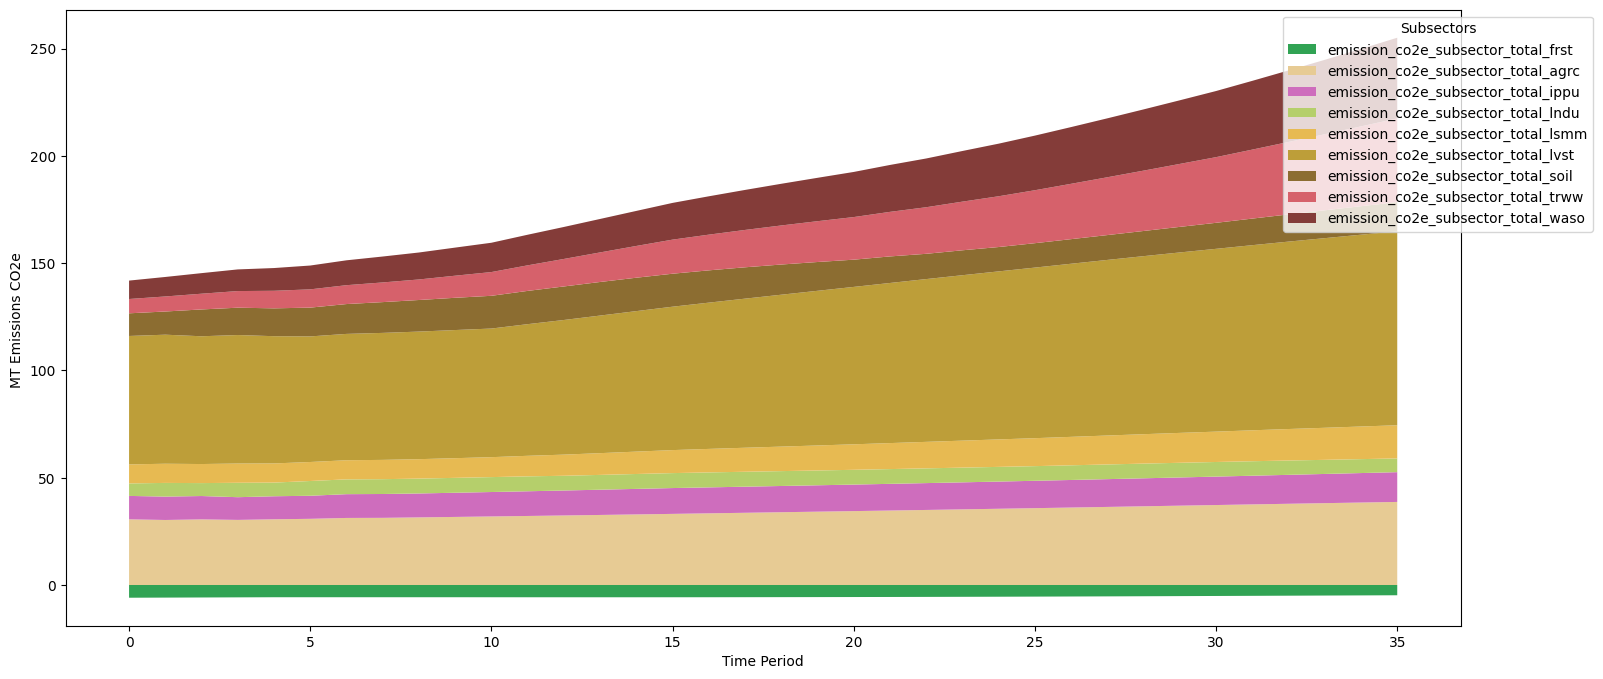

In [76]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([0])
]


fields = [
'emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ippu']

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

## NDC

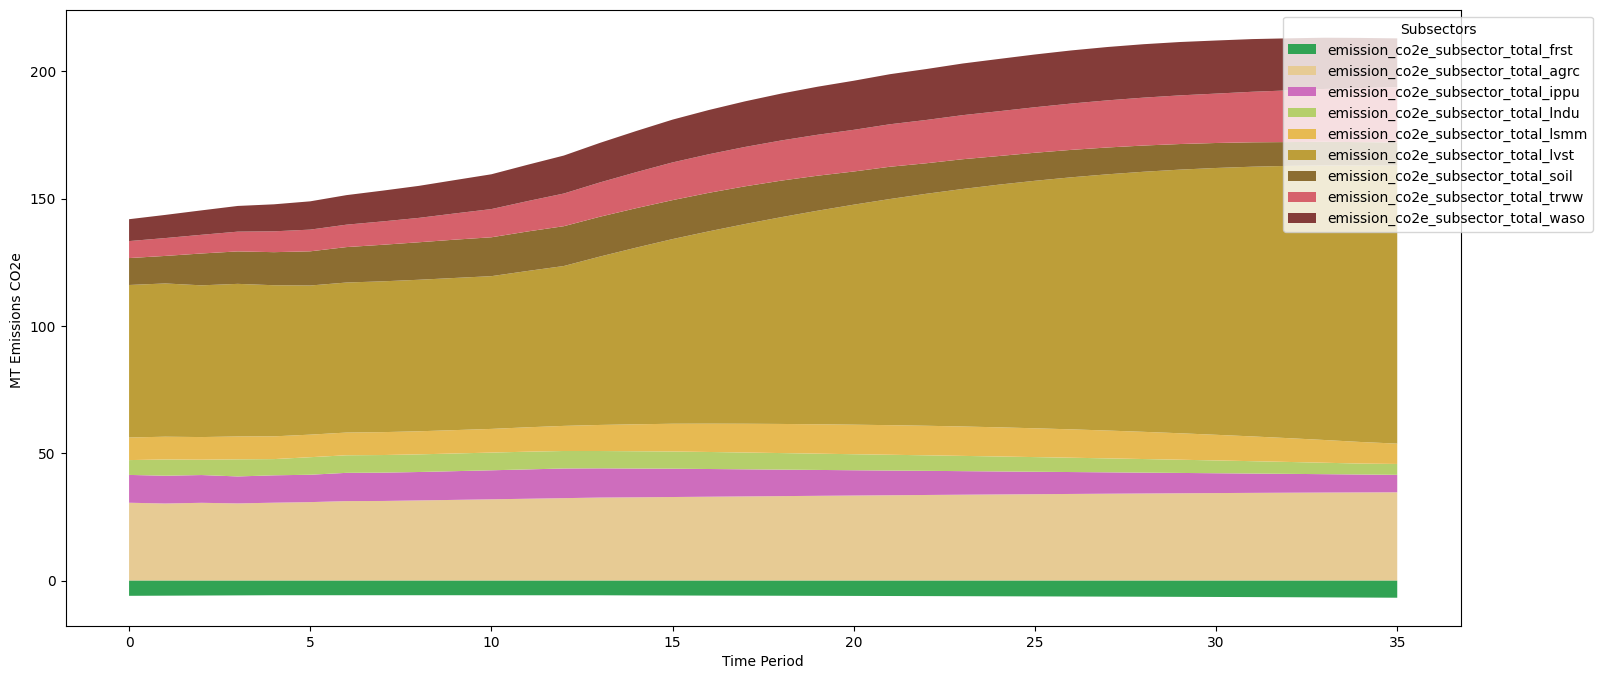

In [77]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([69069])
]


dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

## Net Zero

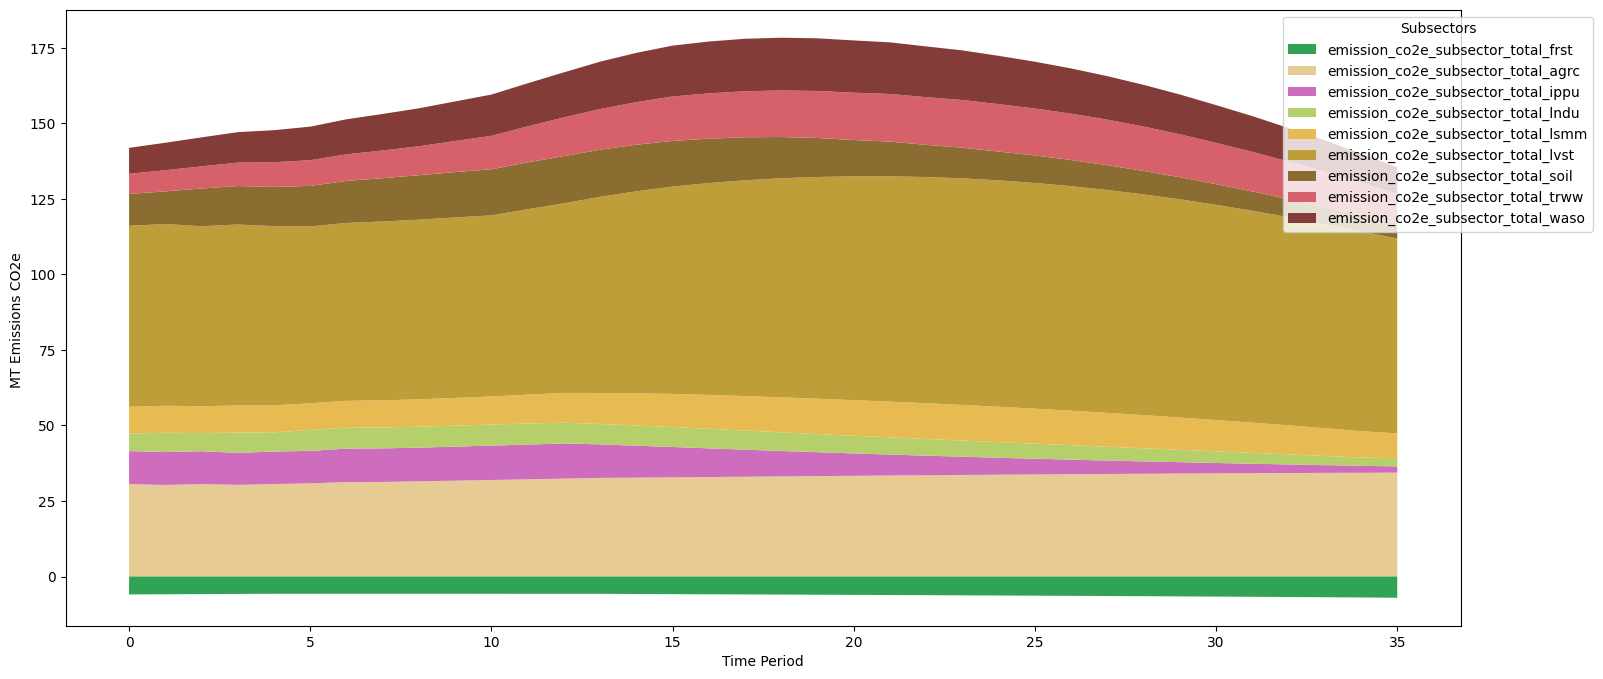

In [78]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([70070])
]

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

## BAU

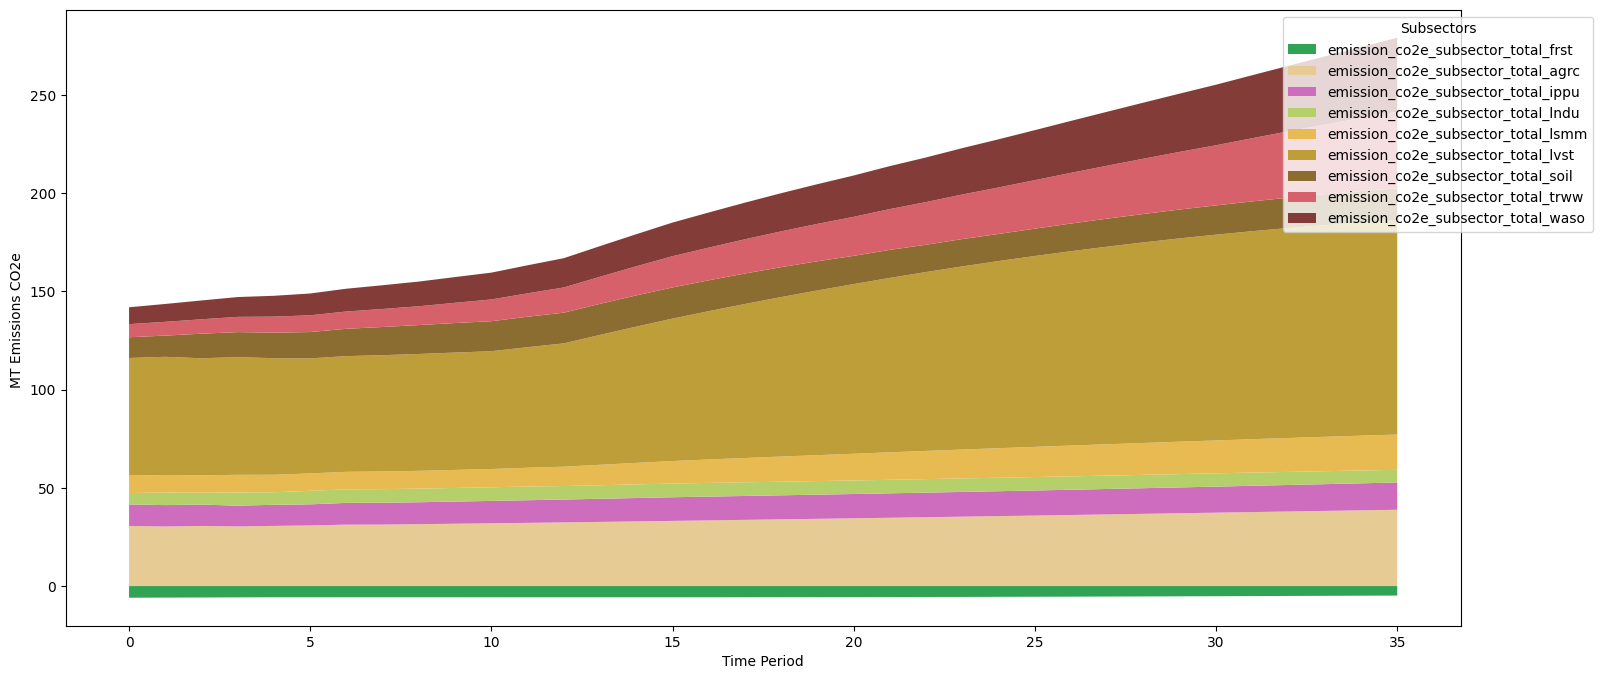

In [79]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title="Subsectors")

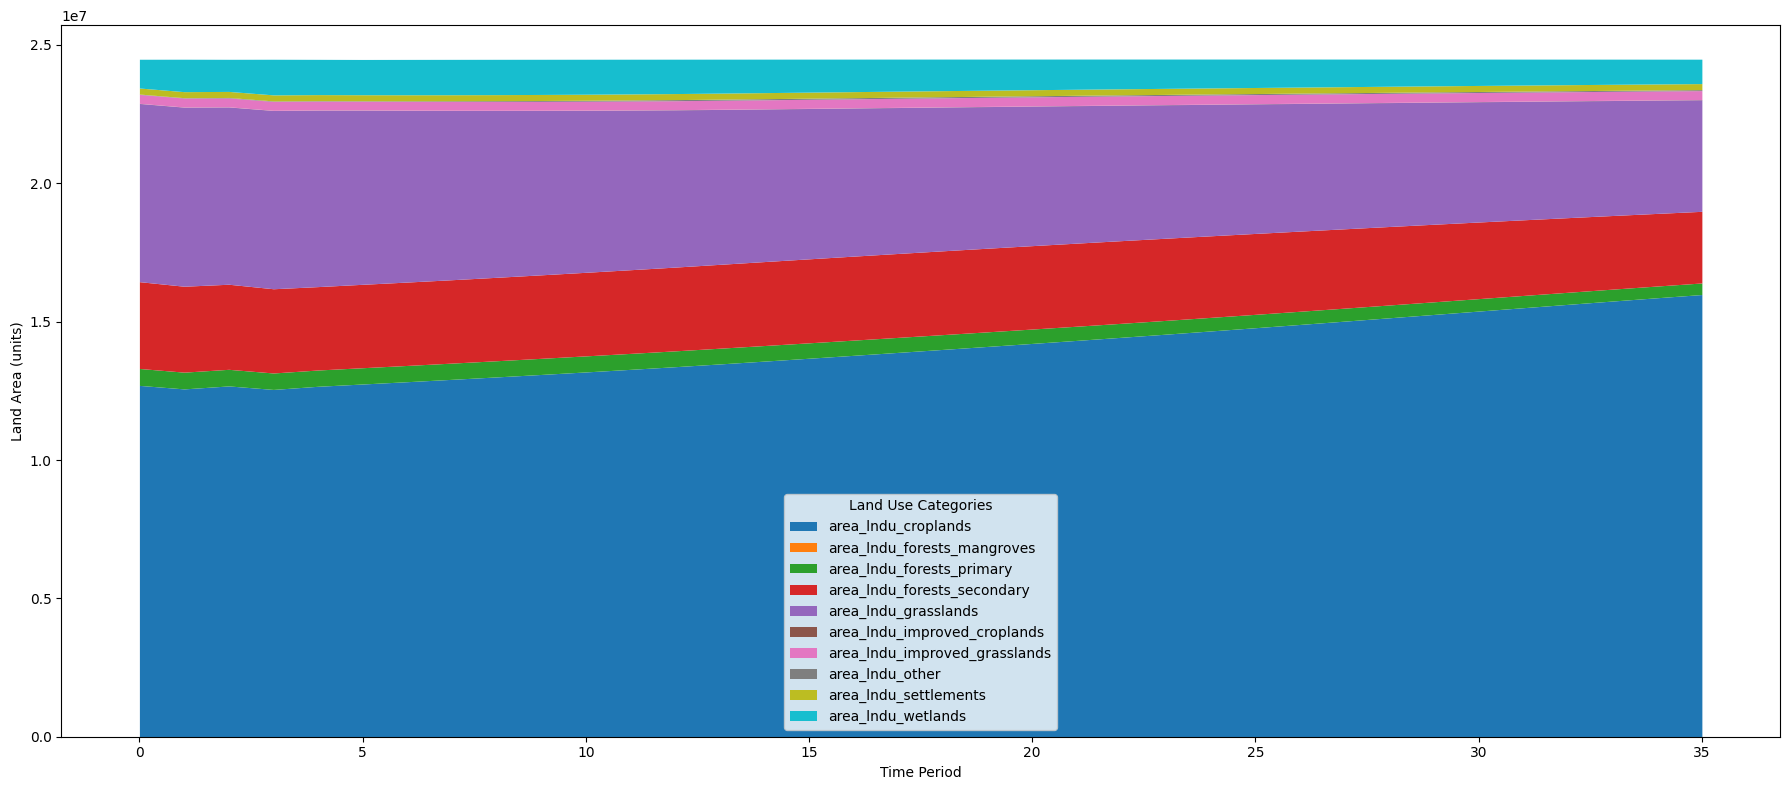

In [80]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 0]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8) ,linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()


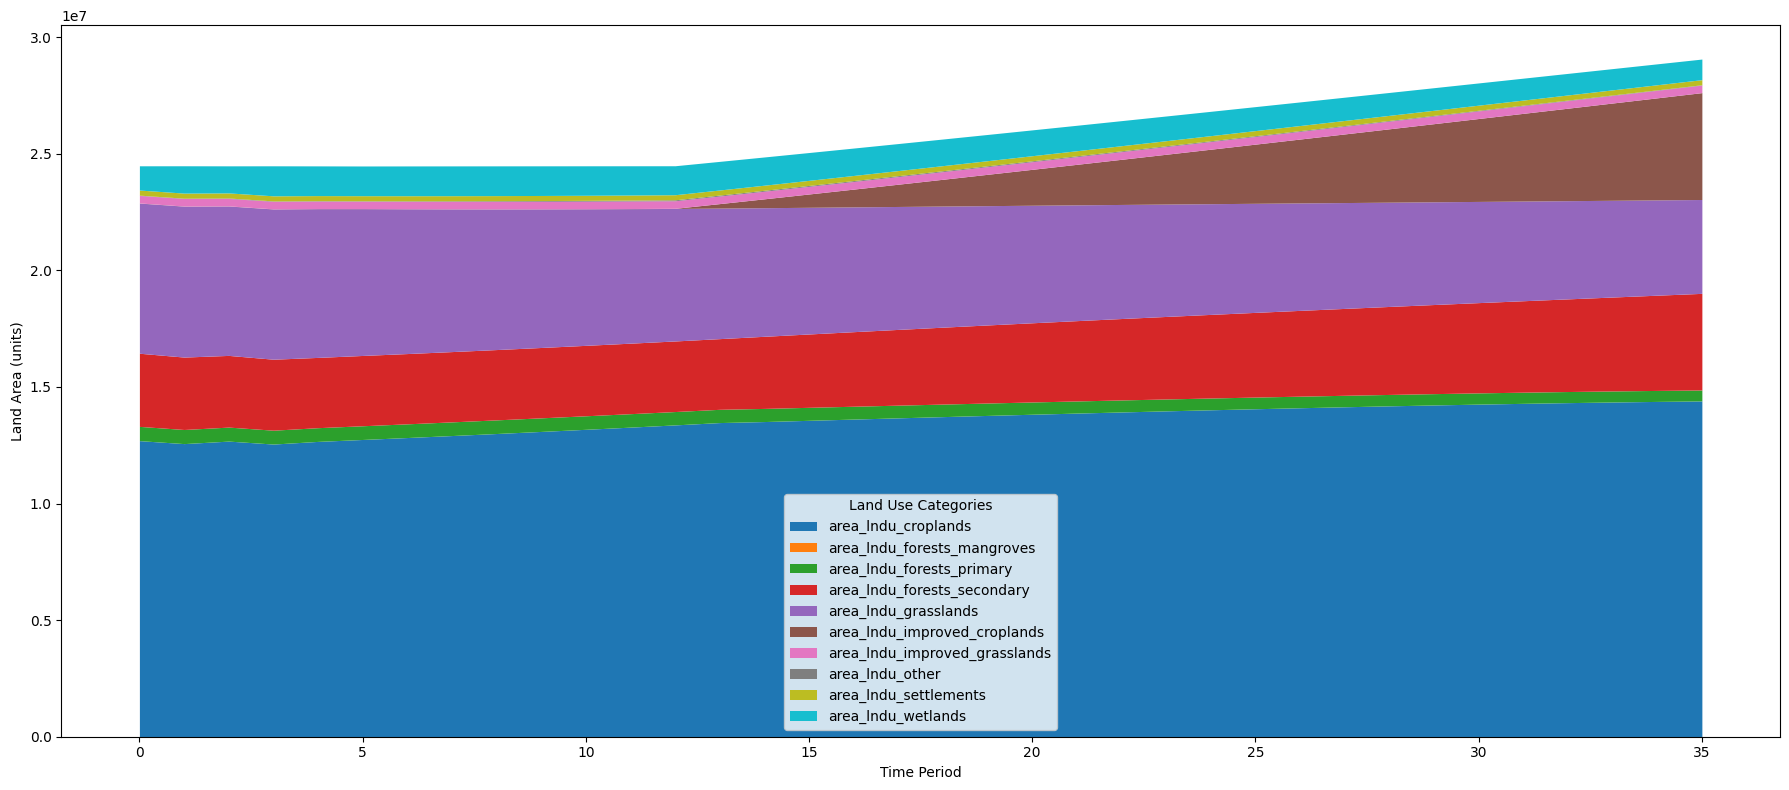

In [81]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 69069]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend(title="Land Use Categories")

plt.tight_layout()
plt.show()


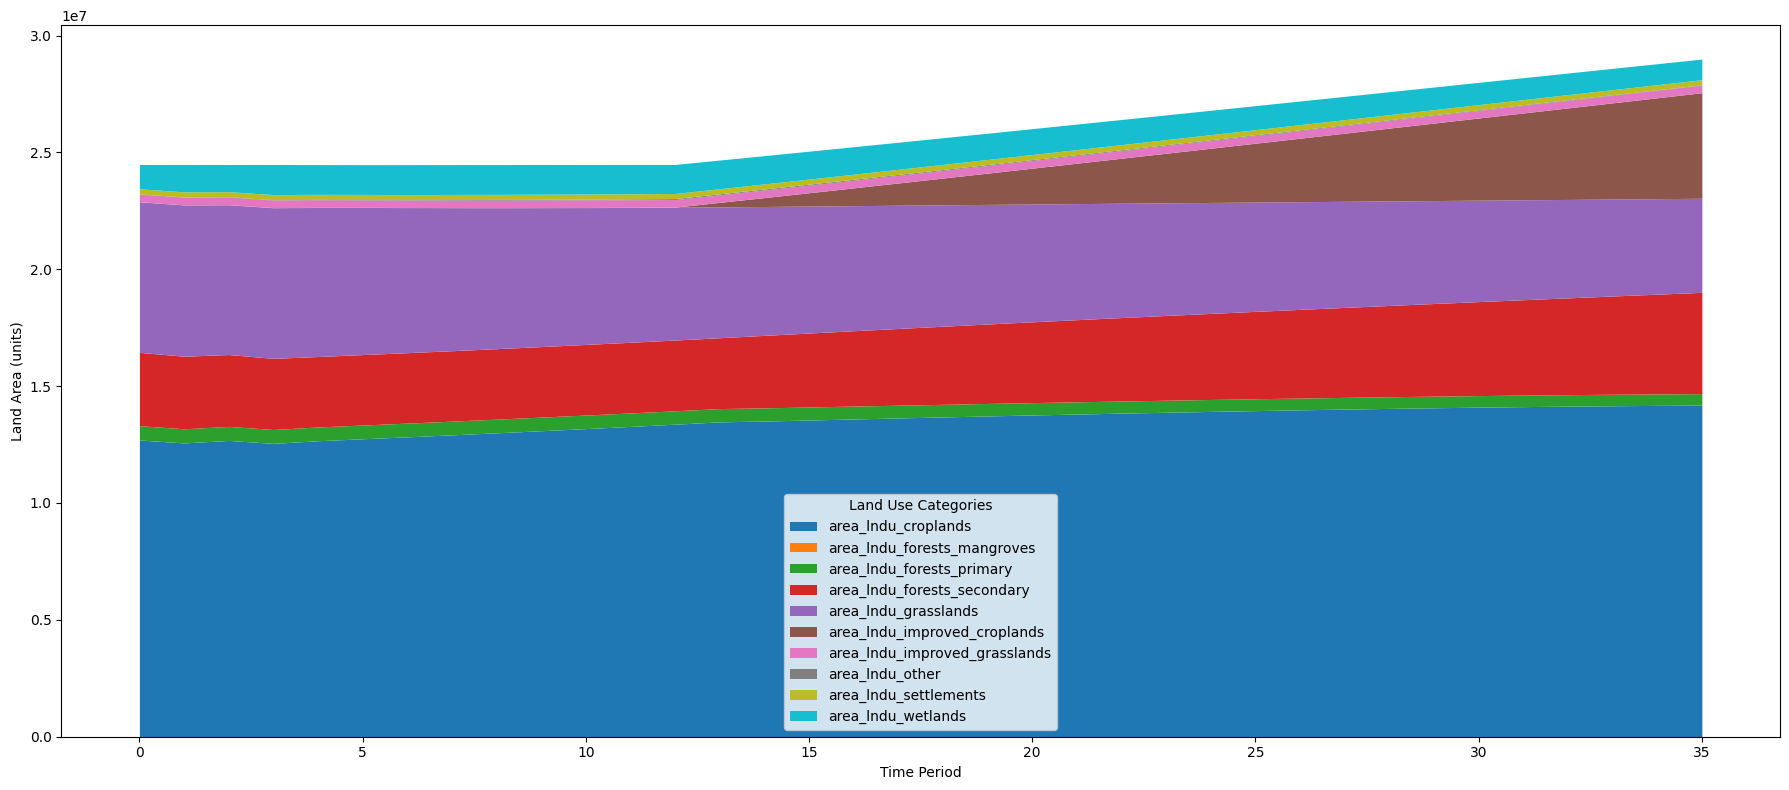

In [82]:
# Filtrar el dataframe
df_plot = df_out[df_out[ssp.key_primary] == 70070]

# Lista de variables a graficar
areas = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Crear el DataFrame para el área
df_area = df_plot.set_index("time_period")[areas]

# Graficar el área apilada
ax = df_area.plot.area(figsize=(18, 8), linewidth=0)

# Etiquetas y título
ax.set_xlabel("Time Period")
ax.set_ylabel("Land Area (units)")
ax.legend( title="Land Use Categories")

plt.tight_layout()
plt.show()

## Desorestation

In [83]:
areas= [
    'emission_co2e_ch4_lndu_wetlands',
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_other",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_mangroves_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_primary_to_wetlands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_croplands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_mangroves",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_primary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_forests_secondary",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_grasslands",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_other",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_settlements",
    "emission_co2e_co2_lndu_conversion_forests_secondary_to_wetlands"
]

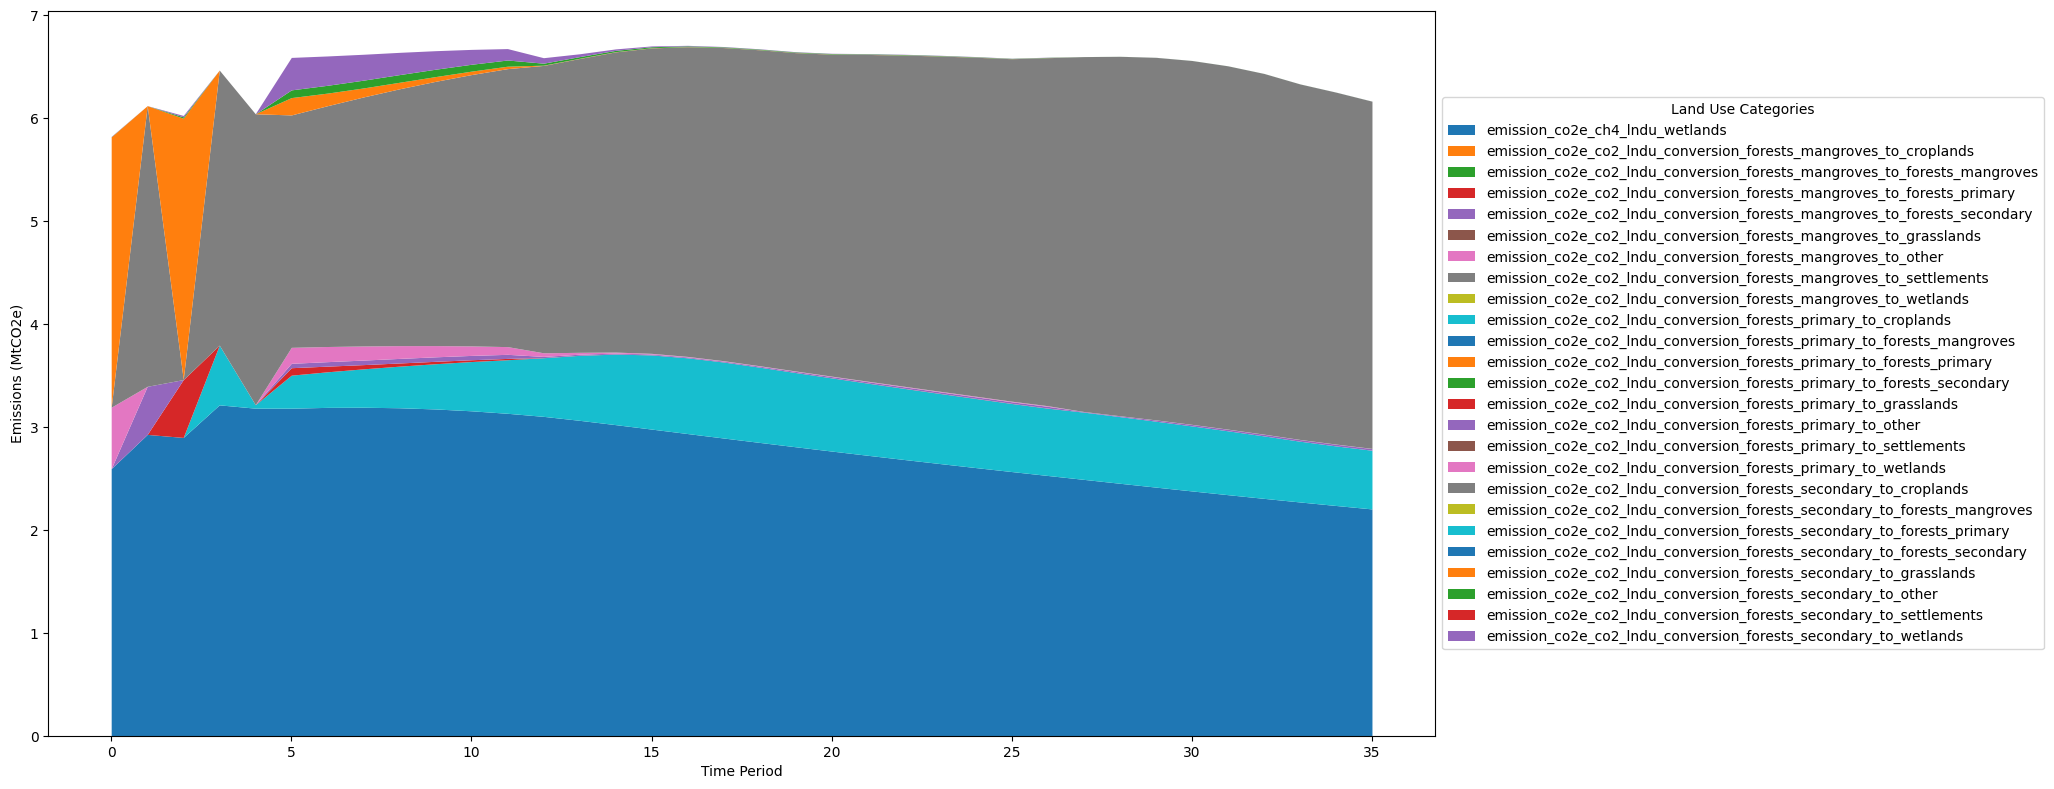

In [84]:
# ---- CONFIGURACIÓN DEL FILTRO ----
key_value = 0  # Cambia este valor para filtrar por otro escenario o clave

# ---- FILTRAR EL DATAFRAME ----
df_plot = df_out[df_out[ssp.key_primary] == key_value]

# ---- CREAR DATAFRAME DE ÁREA ----
df_area = df_plot.set_index("time_period")[areas]

# ---- GRAFICAR ÁREA APILADA ----
fig, ax = plt.subplots(figsize=(18, 8))
df_area.plot.area(ax=ax, linewidth=0)

# ---- CONFIGURAR LEYENDA Y ETIQUETAS ----
ax.set_xlabel("Time Period")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(title="Land Use Categories", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()


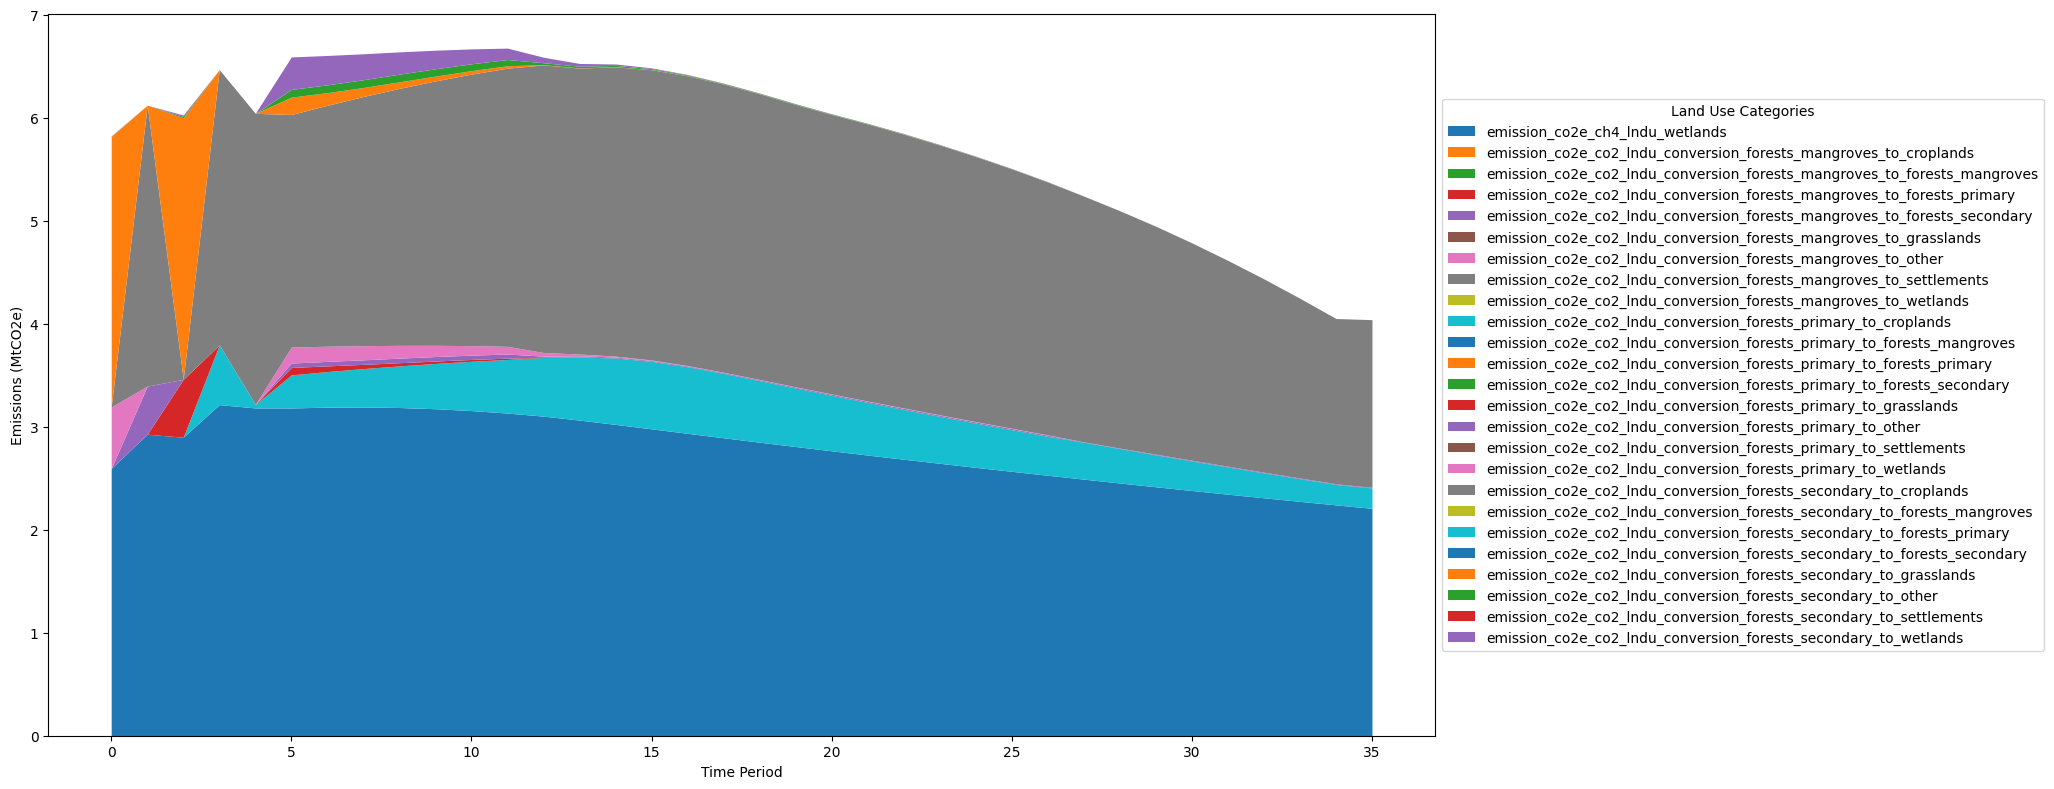

In [85]:
# ---- CONFIGURACIÓN DEL FILTRO ----
key_value = 69069  # Cambia este valor para filtrar por otro escenario o clave

# ---- FILTRAR EL DATAFRAME ----
df_plot = df_out[df_out[ssp.key_primary] == key_value]

# ---- CREAR DATAFRAME DE ÁREA ----
df_area = df_plot.set_index("time_period")[areas]

# ---- GRAFICAR ÁREA APILADA ----
fig, ax = plt.subplots(figsize=(18, 8))
df_area.plot.area(ax=ax, linewidth=0)

# ---- CONFIGURAR LEYENDA Y ETIQUETAS ----
ax.set_xlabel("Time Period")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(title="Land Use Categories", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()

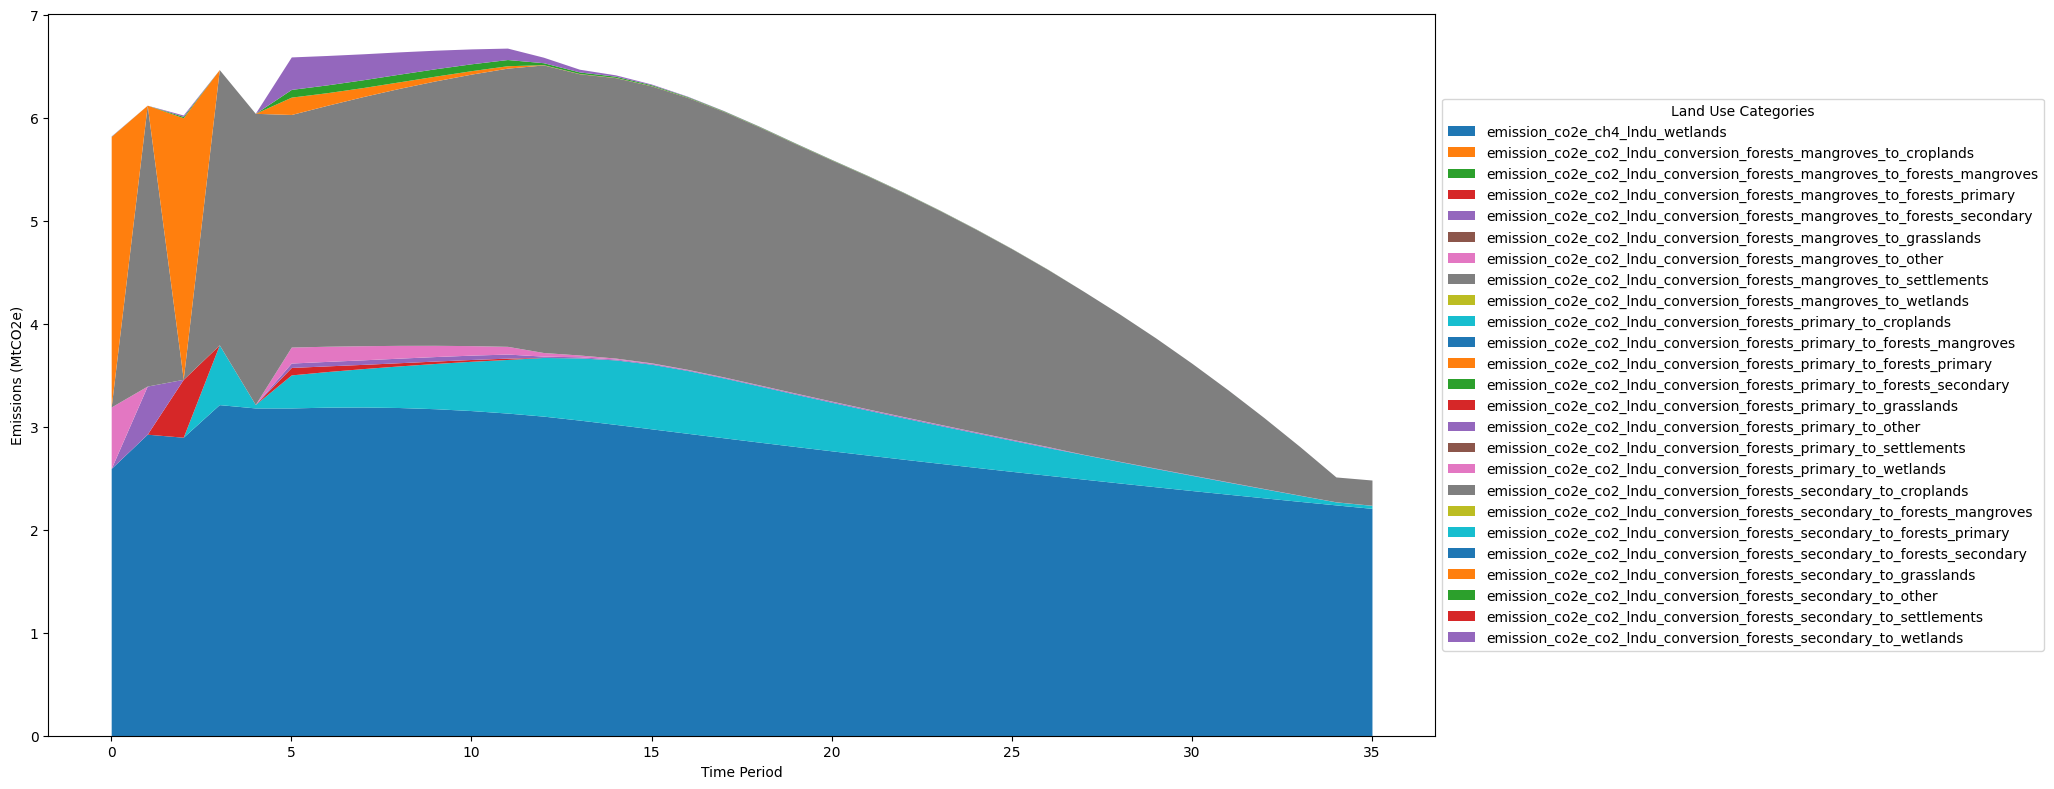

In [86]:
# ---- CONFIGURACIÓN DEL FILTRO ----
key_value = 70070  # Cambia este valor para filtrar por otro escenario o clave

# ---- FILTRAR EL DATAFRAME ----
df_plot = df_out[df_out[ssp.key_primary] == key_value]

# ---- CREAR DATAFRAME DE ÁREA ----
df_area = df_plot.set_index("time_period")[areas]

# ---- GRAFICAR ÁREA APILADA ----
fig, ax = plt.subplots(figsize=(18, 8))
df_area.plot.area(ax=ax, linewidth=0)

# ---- CONFIGURAR LEYENDA Y ETIQUETAS ----
ax.set_xlabel("Time Period")
ax.set_ylabel("Emissions (MtCO2e)")
ax.legend(title="Land Use Categories", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()

# Export Wide File (Last Mandatory Step)

In [87]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [88]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/fabian_fuentes/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'

In [89]:
df_primary.to_csv(
    os.path.join(dir_out, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_out, f"sisepuede_results_sisepuede_bau_run.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_out, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")